# imports

In [1]:
import pandas as pd
import numpy as np

In [25]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
from statsmodels.tsa.stattools import adfuller

# csv to dataframe

In [4]:
raw_data_df = pd.read_csv('/home/mrstoian/code/mrstoian/btc_sent_fc/raw_data/coinbase_2014-2021.csv')

In [5]:
raw_data_df['time'] = pd.to_datetime(raw_data_df['time'])
raw_data_df

,time,close,high,low,open,volumeto,volumefrom,mean_price,volumefrom_USD,volume_net,volume_gross,volume_gross_30
0,2014-12-01,370.00,370.00,300.00,300.00,1.953000e+01,0.05656,335.000,1.894760e+01,5.824000e-01,3.847760e+01,NaN
1,2014-12-02,378.00,378.00,370.00,370.00,5.675070e+03,15.01000,374.000,5.613740e+03,6.133000e+01,1.128881e+04,NaN
2,2014-12-03,378.00,378.00,377.01,378.00,2.065200e+02,0.54660,377.505,2.063442e+02,1.757670e-01,4.128642e+02,NaN
3,2014-12-04,377.10,378.00,377.10,378.00,3.771000e+00,0.01000,377.550,3.775500e+00,-4.500000e-03,7.546500e+00,NaN
4,2014-12-06,378.00,378.00,377.10,377.10,5.670000e+00,0.01500,377.550,5.663250e+00,6.750000e-03,1.133325e+01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2509,2021-11-18,56898.00,60977.21,56514.13,60351.51,1.566051e+09,26742.24000,58745.670,1.570991e+09,-4.939710e+06,3.137042e+09,1.702896e+09
2510,2021-11-19,58122.16,58412.12,55625.00,56898.00,1.062148e+09,18548.35000,57018.560,1.057600e+09,4.548207e+06,2.119749e+09,1.689764e+09
2511,2021-11-20,59760.76,59900.00,57423.35,58122.16,4.448062e+08,7582.40000,58661.675,4.447963e+08,9.868630e+03,8.896024e+08,1.618839e+09
2512,2021-11-21,58671.21,60070.00,58509.69,59760.76,3.945169e+08,6660.78000,59289.845,3.949166e+08,-3.996892e+05,7.894335e+08,1.574183e+09


In [6]:
raw_data_df = raw_data_df[raw_data_df['time'] >= "2016-01-01"]

In [7]:
raw_data_df.set_index('time', inplace=True)

In [8]:
gross_volume_df = raw_data_df[['volume_gross']]

In [9]:
gross_volume_df

,volume_gross
time,
2016-01-01,3.371161e+06
2016-01-02,2.852855e+06
2016-01-03,3.376339e+06
2016-01-04,5.063019e+06
2016-01-05,4.434725e+06
...,...
2021-11-18,3.137042e+09
2021-11-19,2.119749e+09
2021-11-20,8.896024e+08


# finding the hyperparameter i

In [10]:
gross_volume_df['log'] = np.log(gross_volume_df.volume_gross)

/tmp/ipykernel_2584/2540036761.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gross_volume_df['log'] = np.log(gross_volume_df.volume_gross)


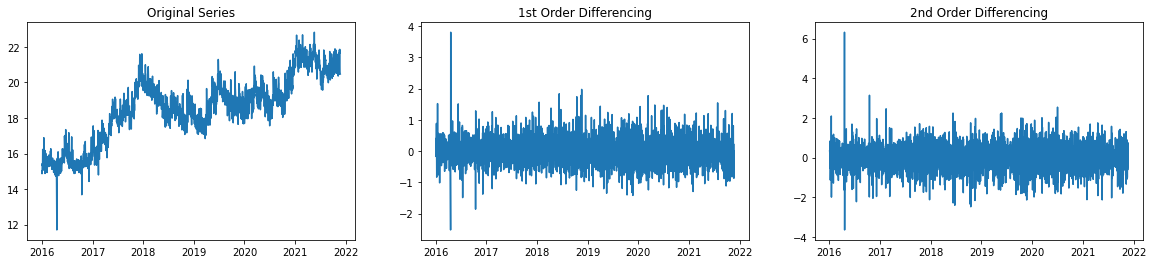

In [11]:
# Let's check the first diffs
zero_diff = gross_volume_df.log
first_order_diff = gross_volume_df.log.diff(1)
second_order_diff = gross_volume_df.log.diff(1).diff(1)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
ax1.plot(zero_diff); ax1.set_title('Original Series')
ax2.plot(first_order_diff); ax2.set_title('1st Order Differencing')
ax3.plot(second_order_diff); ax3.set_title('2nd Order Differencing');

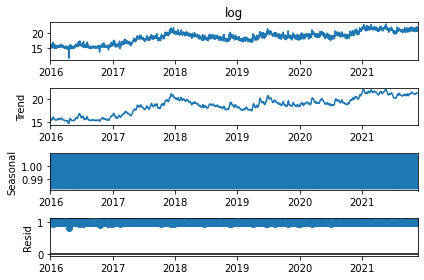

In [12]:
result_mul = seasonal_decompose(gross_volume_df['log'], model='multiplicative',period=7)
result_mul.plot();

In [13]:
# Let's remove seasons
gross_volume_df['deseasonalized'] = gross_volume_df.log/result_mul.seasonal

/tmp/ipykernel_2584/165657168.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gross_volume_df['deseasonalized'] = gross_volume_df.log/result_mul.seasonal


In [14]:
linearized_df = gross_volume_df

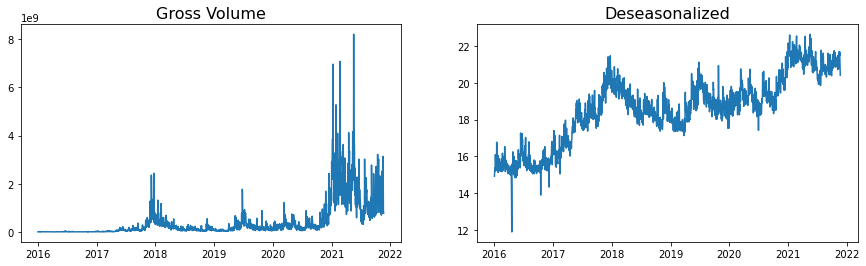

In [15]:
plt.figure(figsize=(15,4)); plt.subplot(1,2,1); plt.plot(gross_volume_df.volume_gross);
plt.title('Gross Volume', fontsize=16);

plt.subplot(1,2,2); plt.plot(linearized_df['deseasonalized'])
plt.title('Deseasonalized', fontsize=16);

In [16]:
# automatically estimate differencing term
ndiffs(linearized_df['deseasonalized'])

1

In [17]:
# take the first order diff -> d=1
first_order_diff_lin = linearized_df.deseasonalized

In [18]:
adfuller(first_order_diff_lin)[1] #checking the p-val

0.36666634943928733

/home/mrstoian/.pyenv/versions/3.8.12/envs/btc_sent_fc/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


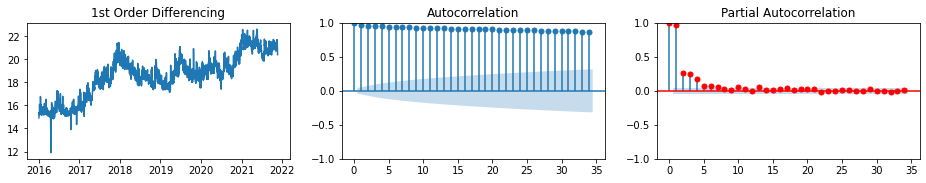

In [19]:
# ACF / PACF analysis of y_diff linearized
fig, axes = plt.subplots(1,3, figsize=(16,2.5))
axes[0].plot(first_order_diff_lin); axes[0].set_title('1st Order Differencing')
plot_acf(first_order_diff_lin, ax=axes[1]);
plot_pacf(first_order_diff_lin, ax=axes[2], c='r');

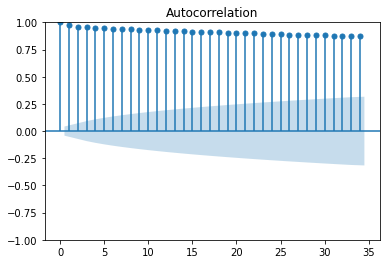

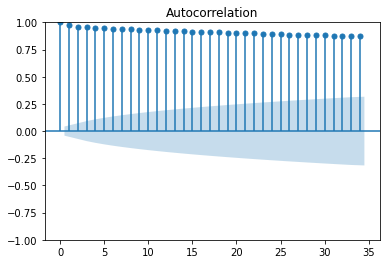

In [20]:
plot_acf(first_order_diff_lin) # q=3

/home/mrstoian/.pyenv/versions/3.8.12/envs/btc_sent_fc/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


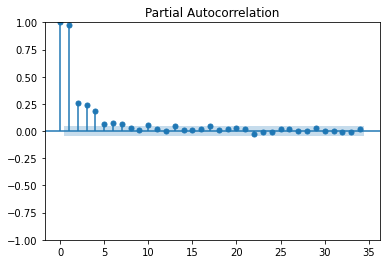

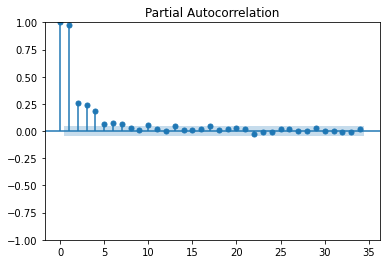

In [21]:
plot_pacf(first_order_diff_lin)

In [22]:
smodel = pm.auto_arima(first_order_diff_lin,
                       start_p=1, max_p=7,
                       start_q=1, max_q=5,
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2000.760, Time=1.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2453.551, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2282.189, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2094.723, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2451.628, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1997.771, Time=1.30 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2136.019, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1999.039, Time=1.77 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1999.623, Time=2.68 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1997.767, Time=1.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1998.169, Time=0.66 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1996.629, Time=3.55 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1997.327, Time=2.01 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1998.453, Time=8.62 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept

In [26]:
arima = ARIMA(first_order_diff_lin, order=(1,1,5))
arima = arima.fit()
arima.summary()

/home/mrstoian/.pyenv/versions/3.8.12/envs/btc_sent_fc/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/mrstoian/.pyenv/versions/3.8.12/envs/btc_sent_fc/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/mrstoian/.pyenv/versions/3.8.12/envs/btc_sent_fc/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         deseasonalized   No. Observations:                 2153
Model:                 ARIMA(1, 1, 5)   Log Likelihood                -987.050
Date:                Wed, 24 Nov 2021   AIC                           1988.100
Time:                        17:49:34   BIC                           2027.819
Sample:                             0   HQIC                          2002.630
                               - 2153                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8493      0.075     11.311      0.000       0.702       0.996
ma.L1         -1.2953      0.076    -17.047      0.000      -1.444      -1.146
ma.L2          0.1697      0.046      3.658      0.000       0.079       0.261
ma.L3          0.1370      0.037      3.683      0.000       0.064       0.210
ma.L4          0.0841      0.034      2.497      0.013       0.018       0.150
ma.L5         -0.0606      0.022     -2.761      0.006      -0.104      -0.018
sigma2         0.1465      0.003     53.387      0.000       0.141       0.152
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1060.82
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.57
Prob(H) (two-sided):                  0.18   Kurtosis:                         6.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
len(first_order_diff_lin)

2153

In [28]:
# Create a correct Training/Test split to predict the last 50 points
train = first_order_diff_lin.head(2100)
test = first_order_diff_lin.tail(53)

# Build Model
arima = ARIMA(train, order=(1,1,5))  
arima = arima.fit()

/home/mrstoian/.pyenv/versions/3.8.12/envs/btc_sent_fc/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/mrstoian/.pyenv/versions/3.8.12/envs/btc_sent_fc/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/mrstoian/.pyenv/versions/3.8.12/envs/btc_sent_fc/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [30]:
forecast = arima.get_forecast(53)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.05)

/home/mrstoian/.pyenv/versions/3.8.12/envs/btc_sent_fc/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [34]:
yhat

2100    20.621948
2101    20.608558
2102    20.605070
2103    20.621488
2104    20.630833
2105    20.638741
2106    20.645435
2107    20.651101
2108    20.655897
2109    20.659955
2110    20.663391
2111    20.666298
2112    20.668759
2113    20.670842
2114    20.672605
2115    20.674098
2116    20.675361
2117    20.676430
2118    20.677334
2119    20.678100
2120    20.678748
2121    20.679297
2122    20.679761
2123    20.680154
2124    20.680487
2125    20.680768
2126    20.681007
2127    20.681208
2128    20.681379
2129    20.681524
2130    20.681646
2131    20.681749
2132    20.681837
2133    20.681911
2134    20.681974
2135    20.682027
2136    20.682072
2137    20.682110
2138    20.682142
2139    20.682170
2140    20.682193
2141    20.682212
2142    20.682229
2143    20.682243
2144    20.682255
2145    20.682265
2146    20.682273
2147    20.682280
2148    20.682286
2149    20.682291
2150    20.682296
2151    20.682299
2152    20.682303
Name: predicted_mean, dtype: float64

In [35]:
# We define here a "Plot forecast vs. real", which also shows historical train set

def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

In [37]:
yhat_conf_int

,lower deseasonalized,upper deseasonalized
2100,19.868244,21.375652
2101,19.746945,21.470170
2102,19.705403,21.504737
2103,19.692767,21.550210
2104,19.663597,21.598068
2105,19.638287,21.639196
2106,19.615812,21.675059
2107,19.595463,21.706740
2108,19.576737,21.735057
2109,19.559271,21.760640


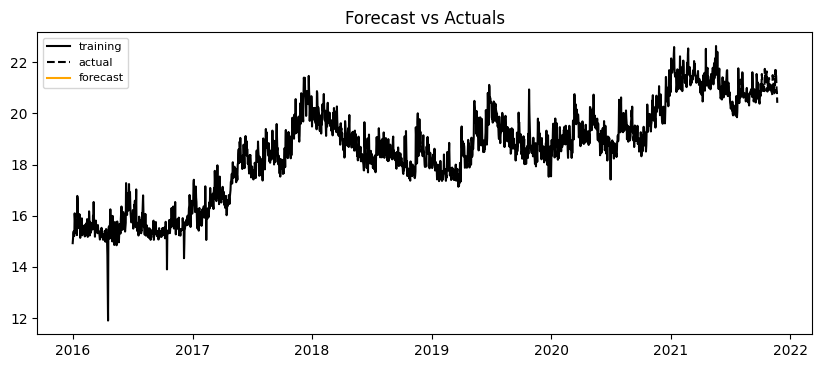

In [38]:
plot_forecast(yhat, train, test, yhat_conf_int['lower deseasonalized'], yhat_conf_int['upper deseasonalized'])

In [41]:
test #actuals

time
2021-10-01    21.173029
2021-10-02    20.677987
2021-10-03    20.797801
2021-10-04    20.946434
2021-10-05    21.161412
2021-10-06    21.541353
2021-10-07    21.065444
2021-10-08    20.871761
2021-10-09    20.797130
2021-10-10    21.104193
2021-10-11    21.067639
2021-10-12    21.129009
2021-10-13    21.035997
2021-10-14    20.871481
2021-10-15    21.742100
2021-10-16    21.282686
2021-10-17    21.188503
2021-10-18    21.547840
2021-10-19    21.374016
2021-10-20    21.462946
2021-10-21    21.642207
2021-10-22    21.331784
2021-10-23    20.854846
2021-10-24    21.122194
2021-10-25    20.931117
2021-10-26    21.000446
2021-10-27    21.351093
2021-10-28    21.385727
2021-10-29    21.222932
2021-10-30    20.879198
2021-10-31    21.108284
2021-11-01    21.019437
2021-11-02    21.132311
2021-11-03    21.022245
2021-11-04    20.856356
2021-11-05    20.845302
2021-11-06    20.801843
2021-11-07    20.717859
2021-11-08    21.498896
2021-11-09    21.295745
2021-11-10    21.466739
2021-11-11 

In [40]:
yhat.tail(53) # predictions

2100    20.621948
2101    20.608558
2102    20.605070
2103    20.621488
2104    20.630833
2105    20.638741
2106    20.645435
2107    20.651101
2108    20.655897
2109    20.659955
2110    20.663391
2111    20.666298
2112    20.668759
2113    20.670842
2114    20.672605
2115    20.674098
2116    20.675361
2117    20.676430
2118    20.677334
2119    20.678100
2120    20.678748
2121    20.679297
2122    20.679761
2123    20.680154
2124    20.680487
2125    20.680768
2126    20.681007
2127    20.681208
2128    20.681379
2129    20.681524
2130    20.681646
2131    20.681749
2132    20.681837
2133    20.681911
2134    20.681974
2135    20.682027
2136    20.682072
2137    20.682110
2138    20.682142
2139    20.682170
2140    20.682193
2141    20.682212
2142    20.682229
2143    20.682243
2144    20.682255
2145    20.682265
2146    20.682273
2147    20.682280
2148    20.682286
2149    20.682291
2150    20.682296
2151    20.682299
2152    20.682303
Name: predicted_mean, dtype: float64